## 1. NER Training

In [1]:
import os
import time

import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report

from datasets import load_dataset
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)

import synthetic_data as syntd
import txt_lab
import utils
from bio_label_aligner import (
    LabelsTokenizerAligner,
    prepare_example_for_dataset
)

### 1.1 Data Prep

In [ ]:
SPLIT_DS_ROOT_P = './data_temp/2025-08-25_NER_Split'
os.makedirs(SPLIT_DS_ROOT_P, exist_ok=True)

TRAIN_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_train.json')

TEST_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test.json')
TEST_REAL_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test_real.json')
TEST_SYNT_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test_synt.json')

SPLIT_CATS_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_cats_map.json')

In [3]:
def count_json_records(path: str) -> int:
    """
    Быстро подсчитывает число элементов в JSON-файле списком,
    без сохранения всего в память: читает по streaming.
    """
    count = 0
    for _ in load_dataset("json", data_files=[path], split="train", streaming=True):
        count += 1
    return count


train_n = count_json_records(TRAIN_P)
test_n  = count_json_records(TEST_P)
print(f"Train records (streaming count): {train_n}")
print(f"Test  records (streaming count): {test_n}")

Train records (streaming count): 69636
Test  records (streaming count): 10000


In [4]:
ds_train_stream = load_dataset(
    "json",
    data_files=[TRAIN_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

ds_test_stream = load_dataset(
    "json",
    data_files=[TEST_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

In [5]:
categories_map = utils.read_json(SPLIT_CATS_P)

bio_labels_to_idx = {"O": 0}
idx = 1
for cat in sorted(categories_map.keys()):
    bio_labels_to_idx[f"B-{cat}"] = idx
    bio_labels_to_idx[f"I-{cat}"] = idx + 1
    idx += 2
bio_labels_to_idx["Ignored"] = -100

idx_to_bio_labels = {v: k for k, v in bio_labels_to_idx.items()}

print(bio_labels_to_idx)

{'O': 0, 'B-address': 1, 'I-address': 2, 'B-azs': 3, 'I-azs': 4, 'B-card': 5, 'I-card': 6, 'B-company': 7, 'I-company': 8, 'B-corp_info': 9, 'I-corp_info': 10, 'B-date': 11, 'I-date': 12, 'B-fuel': 13, 'I-fuel': 14, 'B-greetings': 15, 'I-greetings': 16, 'B-litr': 17, 'I-litr': 18, 'B-mail_info': 19, 'I-mail_info': 20, 'B-money': 21, 'I-money': 22, 'B-payment': 23, 'I-payment': 24, 'B-phone': 25, 'I-phone': 26, 'B-tech_info': 27, 'I-tech_info': 28, 'B-time': 29, 'I-time': 30, 'B-trk': 31, 'I-trk': 32, 'Ignored': -100}


In [6]:
model_checkpoint = "Gherman/bert-base-NER-Russian"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
labels_tokenizer_aligner = LabelsTokenizerAligner(bio_labels_to_idx, tokenizer)

In [7]:
tokenized_train = ds_train_stream.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

tokenized_test = ds_test_stream.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

In [8]:
data_collator = DataCollatorForTokenClassification(tokenizer)

batch_size = 8

### 1.2 Model Training

`Trainer` по умолчанию требует, чтобы train_dataset имел `__len__()`.  
Поскольку мы работаем со streaming-датасетом, у него нет `__len__()` → нужно задать `max_steps`
вручную:

max_steps = (train_n // batch_size) * num_train_epochs

или просто `(train_n // batch_size)` для одной эпохи.

In [47]:
train_n = len(tokenized_train)
test_n = len(tokenized_test)

In [9]:
steps_per_epoch = train_n // batch_size
num_epochs = 11
total_max_steps = steps_per_epoch * num_epochs
print(f"Шагов/эпоху = {steps_per_epoch}, всего шагов ({num_epochs} эпох) = {total_max_steps}")

Шагов/эпоху = 8704, всего шагов (11 эпох) = 95744


In [10]:
label2id = {label: idx for label, idx in bio_labels_to_idx.items() if idx >= 0}
id2label = {idx: label for label, idx in label2id.items()}

In [60]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Gherman/bert-base-NER-Russian and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([34]) in the checkpoint and torch.Size([33]) in the model instantiated
- classifier.weight: found shape torch.Size([34, 768]) in the checkpoint and torch.Size([33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def get_trainable(model) -> int:
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    return trainable_params

In [13]:
get_trainable(model)

177288225

In [14]:
# freeze embeddings layer
'''for param in model.model.embeddings.parameters():
    param.requires_grad = False'''

# freeze first layer of encoder
'''for param in model.model.layers[0].parameters():
    param.requires_grad = False'''

# freeze more encoder layers
'''to_freeze = range(1, 12)
for layer_idx in to_freeze:
    for param in model.model.layers[layer_idx].parameters():
        param.requires_grad = False'''

# freeze entire encoder model
'''for param in model.model.parameters():
    param.requires_grad = False'''

# freeze head
'''for param in model.head.parameters():
    param.requires_grad = False''';

In [15]:
get_trainable(model)

177288225

In [11]:
metric = evaluate.load("seqeval")
label_names = list(label2id.keys())

def compute_metrics(eval_preds: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    true_labels = [
        [label_names[lid] for lid in seq if lid != -100]
        for seq in labels
    ]
    pred_labels = [
        [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
        for pr, seq in zip(preds, labels)
    ]

    scores = metric.compute(predictions=pred_labels, references=true_labels, zero_division=0)
    return {
        "precision": scores["overall_precision"],
        "recall":    scores["overall_recall"],
        "f1":        scores["overall_f1"],
        "accuracy":  scores["overall_accuracy"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./models/ner_model",
    eval_strategy="steps",     
    eval_steps=steps_per_epoch,   
    eval_on_start=True,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_dir="./models/logs",
    save_strategy="steps",     
    save_steps=steps_per_epoch, 
    load_best_model_at_end=True,
    max_steps=total_max_steps,
    
    # group_by_length=True,
    # torch_empty_cache_steps=1,
    # gradient_checkpointing=True,
    # auto_find_batch_size=True
    eval_accumulation_steps=32,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset = tokenized_test,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

In [ ]:
num_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start = time.time()

trainer.train()

elapsed = time.time() - start
mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)

print(f"Количество обучаемых параметров: {num_params}")
print(f"Время: {elapsed:.2f} s")
print(f"Использование памяти gpu: {mem_mb:.2f} MB")

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,3.194526,0.000157,0.000870,0.000266,0.448025
8704,0.033100,0.066968,0.944480,0.955940,0.950175,0.992017
17408,0.030300,0.063687,0.944187,0.963206,0.953602,0.992921
26112,0.019800,0.062827,0.947774,0.965563,0.956586,0.992615
34816,0.017000,0.062225,0.955940,0.965675,0.960783,0.993645
43520,0.015700,0.064522,0.955313,0.965899,0.960577,0.993373
52224,0.011300,0.071030,0.958116,0.967779,0.962923,0.993467
60928,0.010900,0.078603,0.956832,0.968214,0.962489,0.993345
69632,0.006700,0.087187,0.960032,0.967344,0.963674,0.993513
78336,0.007000,0.089681,0.959106,0.967555,0.963312,0.993598


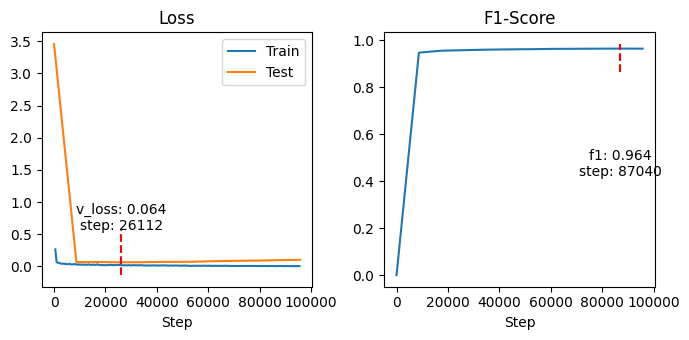

In [ ]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

df_train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
df_test_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

df_train_metrics = df_logs[df_logs["eval_f1"].notna()][["step", "eval_f1"]]

test_loss_best = df_test_loss.iloc[df_test_loss["eval_loss"].argmin().item()]
test_loss_best_step = test_loss_best["step"]
test_loss_best_loss = test_loss_best["eval_loss"]

test_f1_best = df_train_metrics.iloc[df_train_metrics["eval_f1"].argmax().item()]
test_f1_best_step = test_f1_best["step"]
test_f1_best_f1 = test_f1_best["eval_f1"]  


fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

# Loss
axs[0].plot(df_train_loss["step"], df_train_loss["loss"], label="Train")
axs[0].plot(df_test_loss["step"], df_test_loss["eval_loss"], label="Test")
axs[0].set_title("Loss")
axs[0].set_xlabel("Step")
axs[0].legend()

axs[0].plot(
    [test_loss_best_step, test_loss_best_step],
    [test_loss_best_loss-0.2, test_loss_best_loss+0.5],
    'r--',
)
_t_text_y = test_loss_best_loss+0.5
axs[0].text(
    test_loss_best_step, _t_text_y,
    f"v_loss: {round(test_loss_best_loss, 3)}\nstep: {int(test_loss_best_step)}",
    fontsize=10, color='black', ha='center',
)

# F1-Score
axs[1].plot(df_train_metrics["step"], df_train_metrics["eval_f1"])
axs[1].set_title("F1-Score")
axs[1].set_xlabel("Step")

axs[1].plot(
    [test_f1_best_step, test_f1_best_step],
    [test_f1_best_f1-0.1, test_f1_best_f1+0.02],
    'r--',
)
_t_text_y = (df_train_metrics["eval_f1"].min() + test_f1_best_f1-0.12) / 2
axs[1].text(
    test_f1_best_step, _t_text_y,
    f"f1: {round(test_f1_best_f1, 3)}\nstep: {int(test_f1_best_step)}",
    fontsize=10, color='black', ha='center',
)

plt.tight_layout()
plt.show()

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 0.06419921666383743,
 'eval_precision': 0.9505262721124189,
 'eval_recall': 0.9639520857295144,
 'eval_f1': 0.9571921027890943,
 'eval_accuracy': 0.9929416745906928,
 'eval_runtime': 97.0212,
 'eval_samples_per_second': 103.07,
 'eval_steps_per_second': 12.884,
 'epoch': 10.998736358414703}

### 1.3 Evaluation

In [ ]:
ds_test_real = load_dataset(
    "json",
    data_files=[TEST_REAL_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

ds_test_synt = load_dataset(
    "json",
    data_files=[TEST_SYNT_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

In [ ]:
tokenized_real_test = ds_test_real.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

tokenized_synt_test = ds_test_synt.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

#### 1.3.1 Combined

In [ ]:
pred_out = trainer.predict(tokenized_test)
logits = pred_out.predictions
labels = pred_out.label_ids
preds = np.argmax(logits, axis=-1)

true_labels = [
    [label_names[lid] for lid in seq if lid != -100]
    for seq in labels
]
pred_labels = [
    [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
    for pr, seq in zip(preds, labels)
]

y_true_flat = [lbl for seq in true_labels for lbl in seq]
y_pred_flat = [lbl for seq in pred_labels for lbl in seq]

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=label_names)
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
print("Confusion Matrix:")
# cm_df

Confusion Matrix:


In [ ]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Classification Report:
              precision    recall  f1-score   support

     address       0.90      0.93      0.91      1786
         azs       0.99      0.99      0.99      7658
        card       0.94      0.95      0.94      2435
     company       0.91      0.92      0.92      1867
   corp_info       0.97      0.98      0.97     14247
        date       0.94      0.95      0.94      2040
        fuel       0.93      0.96      0.94      1690
   greetings       0.95      0.97      0.96      8728
        litr       0.95      0.97      0.96      1979
   mail_info       0.98      0.99      0.98      4531
       money       0.90      0.91      0.90      2040
     payment       0.73      0.79      0.76      1391
       phone       0.94      0.94      0.94      2456
   tech_info       0.96      0.97      0.96     15502
        time       0.90      0.91      0.91      1606
         trk       0.95      0.97      0.96      1338

   micro avg       0.95      0.96      0.96     71294
  

#### 1.3.2 Real Data

In [ ]:
pred_out = trainer.predict(tokenized_real_test)
logits = pred_out.predictions
labels = pred_out.label_ids
preds = np.argmax(logits, axis=-1)

true_labels = [
    [label_names[lid] for lid in seq if lid != -100]
    for seq in labels
]
pred_labels = [
    [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
    for pr, seq in zip(preds, labels)
]

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Classification Report:
              precision    recall  f1-score   support

     address       0.77      0.82      0.79       666
         azs       0.96      0.96      0.96      1291
        card       0.82      0.85      0.84       796
     company       0.75      0.77      0.76       598
   corp_info       0.82      0.86      0.84      2426
        date       0.87      0.89      0.88       743
        fuel       0.85      0.91      0.88       321
   greetings       0.89      0.93      0.91      3219
        litr       0.82      0.87      0.85       272
   mail_info       0.95      0.97      0.96      2022
       money       0.79      0.83      0.81       486
     payment       0.21      0.30      0.25       196
       phone       0.83      0.86      0.84       894
   tech_info       0.81      0.87      0.84      3303
        time       0.78      0.81      0.80       323
         trk       0.69      0.87      0.77        70

   micro avg       0.84      0.88      0.86     17626
  

#### 1.3.3 Synthetic Data

In [ ]:
pred_out = trainer.predict(tokenized_synt_test)
logits = pred_out.predictions
labels = pred_out.label_ids
preds = np.argmax(logits, axis=-1)

true_labels = [
    [label_names[lid] for lid in seq if lid != -100]
    for seq in labels
]
pred_labels = [
    [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
    for pr, seq in zip(preds, labels)
]

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Classification Report:
              precision    recall  f1-score   support

     address       0.98      0.99      0.98      1120
         azs       1.00      1.00      1.00      6367
        card       0.99      1.00      1.00      1639
     company       0.99      0.99      0.99      1269
   corp_info       1.00      1.00      1.00     11821
        date       0.98      0.98      0.98      1297
        fuel       0.95      0.97      0.96      1369
   greetings       1.00      1.00      1.00      5509
        litr       0.97      0.99      0.98      1707
   mail_info       1.00      1.00      1.00      2509
       money       0.93      0.94      0.93      1554
     payment       0.85      0.87      0.86      1195
       phone       1.00      0.99      0.99      1562
   tech_info       1.00      1.00      1.00     12199
        time       0.93      0.94      0.93      1283
         trk       0.97      0.98      0.97      1268

   micro avg       0.99      0.99      0.99     53668
  

### 1.4 Save and load model 

In [ ]:
model.save_pretrained("./models/ner_model_8_8_shuffle_full_real.bin")
tokenizer.save_pretrained("./models/ner_model_8_8_shuffle_full_real.bin")

('./models/ner_model_8_8_shuffle_full_real.bin\\tokenizer_config.json',
 './models/ner_model_8_8_shuffle_full_real.bin\\special_tokens_map.json',
 './models/ner_model_8_8_shuffle_full_real.bin\\vocab.txt',
 './models/ner_model_8_8_shuffle_full_real.bin\\added_tokens.json',
 './models/ner_model_8_8_shuffle_full_real.bin\\tokenizer.json')

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("./models/ner_model_8_8_shuffle_full_real.bin")
tokenizer = AutoTokenizer.from_pretrained("./models/ner_model_8_8_shuffle_full_real.bin")

In [ ]:
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use cuda:0


In [ ]:
SPLIT_DS_ROOT_P = './data_temp/2025-08-25_NER_Split'
os.makedirs(SPLIT_DS_ROOT_P, exist_ok=True)
SPLIT_TEST_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test.json')
test = utils.read_json(SPLIT_TEST_P)

In [33]:
example = test[144]['text']
print(example)

entities = ner_pipeline(example)
print(entities)
predicted_entities = [
    txt_lab.Entity(beg=ent["start"], end=ent["end"], cat=ent["entity_group"])
    for ent in entities
]
predicted_labeled_text = txt_lab.Text(text=example, entities=predicted_entities)
txt_lab.visualize(predicted_labeled_text, syntd.COLOR_MAP)

Добрый день.Как мне поменять номер телефона в ЛК?
[{'entity_group': 'greetings', 'score': np.float32(0.9902336), 'word': 'Добрый день.', 'start': 0, 'end': 12}]


In [34]:
example = test[600]['text']
print(example)

entities = ner_pipeline(example)
print(entities)
predicted_entities = [
    txt_lab.Entity(beg=ent["start"], end=ent["end"], cat=ent["entity_group"])
    for ent in entities
]
predicted_labeled_text = txt_lab.Text(text=example, entities=predicted_entities)
txt_lab.visualize(predicted_labeled_text, syntd.COLOR_MAP)


Здравствуйте, после оформления ОСАГО в приложении, не пришли бонусы. 

Номер телефона: +7 (913) 577-98-87
[{'entity_group': 'greetings', 'score': np.float32(0.99870706), 'word': 'Здравствуйте', 'start': 1, 'end': 13}, {'entity_group': 'phone', 'score': np.float32(0.9912812), 'word': 'Номер телефона : + 7 ( 913 ) 577 - 98 - 87', 'start': 72, 'end': 106}]


## 2. MLM ner

In [1]:
import os
import time

import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report

from datasets import load_dataset
from datasets import Dataset

from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)

import synthetic_data as syntd
import txt_lab
import utils
from bio_label_aligner import (
    LabelsTokenizerAligner,
    prepare_example_for_dataset
)

In [2]:
SPLIT_DS_ROOT_P = './data_temp/2025-08-25_NER_Split'
os.makedirs(SPLIT_DS_ROOT_P, exist_ok=True)

TRAIN_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_train.json')

TEST_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test.json')
TEST_REAL_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test_real.json')
TEST_SYNT_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test_synt.json')

SPLIT_CATS_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_cats_map.json')

In [3]:
def count_json_records(path: str) -> int:
    """
    Быстро подсчитывает число элементов в JSON-файле списком,
    без сохранения всего в память: читает по streaming.
    """
    count = 0
    for _ in load_dataset("json", data_files=[path], split="train", streaming=True):
        count += 1
    return count


train_n = count_json_records(TRAIN_P)
test_n  = count_json_records(TEST_P)
print(f"Train records (streaming count): {train_n}")
print(f"Test  records (streaming count): {test_n}")

Train records (streaming count): 69636
Test  records (streaming count): 10000


In [4]:
ds_train_stream = load_dataset(
    "json",
    data_files=[TRAIN_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

ds_test_stream = load_dataset(
    "json",
    data_files=[TEST_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

In [5]:
categories_map = utils.read_json(SPLIT_CATS_P)

bio_labels_to_idx = {"O": 0}
idx = 1
for cat in sorted(categories_map.keys()):
    bio_labels_to_idx[f"B-{cat}"] = idx
    bio_labels_to_idx[f"I-{cat}"] = idx + 1
    idx += 2
bio_labels_to_idx["Ignored"] = -100

idx_to_bio_labels = {v: k for k, v in bio_labels_to_idx.items()}

print(bio_labels_to_idx)

{'O': 0, 'B-address': 1, 'I-address': 2, 'B-azs': 3, 'I-azs': 4, 'B-card': 5, 'I-card': 6, 'B-company': 7, 'I-company': 8, 'B-corp_info': 9, 'I-corp_info': 10, 'B-date': 11, 'I-date': 12, 'B-fuel': 13, 'I-fuel': 14, 'B-greetings': 15, 'I-greetings': 16, 'B-litr': 17, 'I-litr': 18, 'B-mail_info': 19, 'I-mail_info': 20, 'B-money': 21, 'I-money': 22, 'B-payment': 23, 'I-payment': 24, 'B-phone': 25, 'I-phone': 26, 'B-tech_info': 27, 'I-tech_info': 28, 'B-time': 29, 'I-time': 30, 'B-trk': 31, 'I-trk': 32, 'Ignored': -100}


In [6]:
MODEL_MLM_DIR = r".\models\deepvk_RuModernBERT-base_patched_tokenizer_MLM"
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_MLM_DIR,
    use_fast=True,
    trust_remote_code=True
)
labels_tokenizer_aligner = LabelsTokenizerAligner(bio_labels_to_idx, tokenizer)

In [7]:
tokenized_train = ds_train_stream.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

tokenized_test = ds_test_stream.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)

In [8]:
lengths = [len(x) for x in tokenized_train["input_ids"]]
df_lengths = pd.DataFrame(lengths, columns=["seq_len"])
df_lengths.describe()

,seq_len
count,69636.000000
mean,318.513642
std,378.879118
min,2.000000
25%,53.000000
50%,176.000000
75%,454.000000
max,26163.000000


In [9]:
df_lengths[df_lengths['seq_len']>=700]

,seq_len
317,1228
1159,1177
1511,833
1522,726
1974,829
...,...
69491,706
69505,709
69514,708
69543,846


In [10]:
def split_long_examples_by_bisection(input_ids, labels, attention_mask, tokenizer, max_len=700):
    """
    Рекурсивная резка последовательности на чанки <= max_len
    с учетом BIO-разметки (делим только по label==0).
    В каждый чанк добавляются [CLS] и [SEP] токены с label=-100.
    """
    cls_id = tokenizer.cls_token_id
    sep_id = tokenizer.sep_token_id

    # убираем начальные/конечные CLS/SEP если они уже есть
    if input_ids[0] == cls_id:
        input_ids = input_ids[1:]
        labels = labels[1:]
        attention_mask = attention_mask[1:]
    if input_ids[-1] == sep_id:
        input_ids = input_ids[:-1]
        labels = labels[:-1]
        attention_mask = attention_mask[:-1]

    n = len(input_ids)

    # если длина нормальная
    if n <= max_len - 2:  # -2, т.к. добавим CLS и SEP
        # добавляем CLS/SEP и -100 для них
        new_ids = [cls_id] + input_ids + [sep_id]
        new_labels = [-100] + labels + [-100]
        new_mask = [1] + attention_mask + [1]
        return [(new_ids, new_labels, new_mask)]

    # иначе режем
    mid = n // 2
    best_split = None
    for offset in range(max_len):
        left = mid - offset
        right = mid + offset
        if left > 0 and labels[left] == 0:
            best_split = left
            break
        if right < n and labels[right] == 0:
            best_split = right
            break
    if best_split is None:
        best_split = mid

    left_chunk = (input_ids[:best_split], labels[:best_split], attention_mask[:best_split])
    right_chunk = (input_ids[best_split:], labels[best_split:], attention_mask[best_split:])

    result = []
    for chunk in [left_chunk, right_chunk]:
        result.extend(split_long_examples_by_bisection(*chunk, tokenizer=tokenizer, max_len=max_len))
    return result


In [11]:
def process_dataset(dataset, tokenizer, max_len=700):
    new_examples = {"input_ids": [], "labels": [], "attention_mask": []}

    for ex in dataset:
        chunks = split_long_examples_by_bisection(
            ex["input_ids"], ex["labels"], ex["attention_mask"], tokenizer, max_len=max_len
        )
        for ids, labs, mask in chunks:
            new_examples["input_ids"].append(ids)
            new_examples["labels"].append(labs)
            new_examples["attention_mask"].append(mask)

    return Dataset.from_dict(new_examples)

In [12]:
tokenized_train = process_dataset(tokenized_train, tokenizer, max_len=700)

In [13]:
tokenized_train

Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 81338
})

In [14]:
def get_trainable(model) -> int:
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    return trainable_params

In [15]:
label2id = {label: idx for label, idx in bio_labels_to_idx.items() if idx >= 0}
id2label = {idx: label for label, idx in label2id.items()}

In [16]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_MLM_DIR,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True, 
    trust_remote_code=True,    
)


Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at .\models\deepvk_RuModernBERT-base_patched_tokenizer_MLM and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
get_trainable(model)

149640225

In [18]:
data_collator = DataCollatorForTokenClassification(tokenizer)

batch_size = 8

In [19]:
def check_label_coverage(dataset):
    total = len(dataset)
    bad = 0
    for ex in dataset:
        has_label = any(l >= 0 for l in ex["labels"])
        if not has_label:
            bad += 1
    print(f"Examples with NO trainable labels: {bad}/{total} ({bad/total:.2%})")

check_label_coverage(tokenized_train)

Examples with NO trainable labels: 2002/81338 (2.46%)


In [20]:
metric = evaluate.load("seqeval")
label_names = list(label2id.keys())

def compute_metrics(eval_preds: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    true_labels = [
        [label_names[lid] for lid in seq if lid != -100]
        for seq in labels
    ]
    pred_labels = [
        [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
        for pr, seq in zip(preds, labels)
    ]

    scores = metric.compute(predictions=pred_labels, references=true_labels, zero_division=0)
    return {
        "precision": scores["overall_precision"],
        "recall":    scores["overall_recall"],
        "f1":        scores["overall_f1"],
        "accuracy":  scores["overall_accuracy"],
    }

In [21]:
train_n = len(tokenized_train)
test_n = len(tokenized_test)

In [22]:
steps_per_epoch = train_n // batch_size
num_epochs = 15
total_max_steps = steps_per_epoch * num_epochs
print(f"Шагов/эпоху = {steps_per_epoch}, всего шагов ({num_epochs} эпох) = {total_max_steps}")

Шагов/эпоху = 10167, всего шагов (15 эпох) = 152505


In [ ]:
training_args = TrainingArguments(
    output_dir="./models/ner_model_from_mlm",
    eval_strategy="steps",     
    eval_steps=steps_per_epoch,   
    eval_on_start=True,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_dir="./models/logs",
    save_strategy="steps",     
    save_steps=steps_per_epoch,
    load_best_model_at_end=True,
    max_steps=total_max_steps,
    
    # group_by_length=True,
    torch_empty_cache_steps=1,
    # gradient_checkpointing=True,
    # auto_find_batch_size=True
    eval_accumulation_steps=32,

    logging_strategy="steps",
    logging_steps=steps_per_epoch, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset = tokenized_test,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

In [24]:
num_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start = time.time()

trainer.train()

elapsed = time.time() - start
mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)

print(f"Количество обучаемых параметров: {num_params}")
print(f"Время: {elapsed:.2f} s")
print(f"Использование памяти gpu: {mem_mb:.2f} MB")

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,5.784695,0.000025,0.000760,0.000049,0.019767
10167,0.033900,0.067595,0.953454,0.961423,0.957422,0.993951
20334,0.016800,0.059958,0.961866,0.969523,0.965679,0.994967
30501,0.013200,0.060680,0.965106,0.971375,0.968230,0.995067
40668,0.010200,0.066382,0.965972,0.970872,0.968416,0.994858
50835,0.008100,0.072967,0.966009,0.971064,0.968530,0.995039
61002,0.006600,0.074947,0.964724,0.972199,0.968447,0.995159
71169,0.005300,0.089246,0.963417,0.972819,0.968095,0.995107
81336,0.004500,0.094161,0.966267,0.971995,0.969123,0.995104
91503,0.003700,0.102083,0.968199,0.972498,0.970344,0.995151


KeyboardInterrupt: 

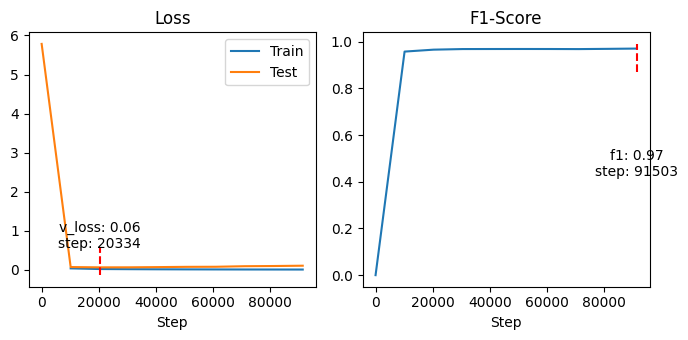

In [25]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

df_train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
df_test_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

df_train_metrics = df_logs[df_logs["eval_f1"].notna()][["step", "eval_f1"]]

test_loss_best = df_test_loss.iloc[df_test_loss["eval_loss"].argmin().item()]
test_loss_best_step = test_loss_best["step"]
test_loss_best_loss = test_loss_best["eval_loss"]

test_f1_best = df_train_metrics.iloc[df_train_metrics["eval_f1"].argmax().item()]
test_f1_best_step = test_f1_best["step"]
test_f1_best_f1 = test_f1_best["eval_f1"]  


fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

# Loss
axs[0].plot(df_train_loss["step"], df_train_loss["loss"], label="Train")
axs[0].plot(df_test_loss["step"], df_test_loss["eval_loss"], label="Test")
axs[0].set_title("Loss")
axs[0].set_xlabel("Step")
axs[0].legend()

axs[0].plot(
    [test_loss_best_step, test_loss_best_step],
    [test_loss_best_loss-0.2, test_loss_best_loss+0.5],
    'r--',
)
_t_text_y = test_loss_best_loss+0.5
axs[0].text(
    test_loss_best_step, _t_text_y,
    f"v_loss: {round(test_loss_best_loss, 3)}\nstep: {int(test_loss_best_step)}",
    fontsize=10, color='black', ha='center',
)

# F1-Score
axs[1].plot(df_train_metrics["step"], df_train_metrics["eval_f1"])
axs[1].set_title("F1-Score")
axs[1].set_xlabel("Step")

axs[1].plot(
    [test_f1_best_step, test_f1_best_step],
    [test_f1_best_f1-0.1, test_f1_best_f1+0.02],
    'r--',
)
_t_text_y = (df_train_metrics["eval_f1"].min() + test_f1_best_f1-0.12) / 2
axs[1].text(
    test_f1_best_step, _t_text_y,
    f"f1: {round(test_f1_best_f1, 3)}\nstep: {int(test_f1_best_step)}",
    fontsize=10, color='black', ha='center',
)

plt.tight_layout()
plt.show()

In [26]:
results = trainer.evaluate()
results

{'eval_loss': 0.1286427080631256,
 'eval_precision': 0.9658274909708944,
 'eval_recall': 0.9729692131536988,
 'eval_f1': 0.9693851984924489,
 'eval_accuracy': 0.995140183129406}

In [27]:
ds_test_real = load_dataset(
    "json",
    data_files=[TEST_REAL_P],
    split="train",
    # streaming=True
).map(
    prepare_example_for_dataset,
    remove_columns=["text", "entities"]
)

tokenized_real_test = ds_test_real.map(
    labels_tokenizer_aligner,
    batched=True,
    remove_columns=["words", "bio_labels"]
)


In [28]:
pred_out = trainer.predict(tokenized_real_test)
logits = pred_out.predictions
labels = pred_out.label_ids
preds = np.argmax(logits, axis=-1)

true_labels = [
    [label_names[lid] for lid in seq if lid != -100]
    for seq in labels
]
pred_labels = [
    [label_names[p] for p, lid in zip(pr, seq) if lid != -100]
    for pr, seq in zip(preds, labels)
]

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Classification Report:
              precision    recall  f1-score   support

     address       0.76      0.83      0.79       726
         azs       0.95      0.96      0.96      1314
        card       0.83      0.86      0.84       793
     company       0.76      0.78      0.77       625
   corp_info       0.86      0.89      0.87      2490
        date       0.86      0.88      0.87       766
        fuel       0.84      0.89      0.87       333
   greetings       0.90      0.93      0.91      3236
        litr       0.81      0.88      0.85       279
   mail_info       0.95      0.97      0.96      2035
       money       0.81      0.82      0.82       499
     payment       0.24      0.28      0.26       189
       phone       0.81      0.86      0.84       901
   tech_info       0.83      0.88      0.86      3411
        time       0.83      0.82      0.83       333
         trk       0.72      0.80      0.76        71

   micro avg       0.86      0.89      0.87     18001
  

In [29]:
model.save_pretrained("./models/ner_mlm.bin")
tokenizer.save_pretrained("./models/ner_mlm.bin")

('./models/ner_mlm.bin\\tokenizer_config.json',
 './models/ner_mlm.bin\\special_tokens_map.json',
 './models/ner_mlm.bin\\tokenizer.json')

## 2. Postprocess

Метрики по обработанным сущностям

In [1]:
import os
import json

from transformers import (
    pipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)

import utils
import txt_lab
import synthetic_data as syntd

from ner.text_cleaning import clean_entity_span
from ner.metrics import get_entity_report
from ner.thresholding import pick_thresholds_by_max_f1

In [2]:
checkpoint_path = "./models/ner_mlm.bin"

model = AutoModelForTokenClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use cuda:0


In [3]:
# Собираем очищенные истинные спаны из исходного теста
SPLIT_DS_ROOT_P = './data_temp/2025-08-25_NER_Split'
os.makedirs(SPLIT_DS_ROOT_P, exist_ok=True)
SPLIT_TEST_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test.json')
raw_test = utils.read_json(SPLIT_TEST_P)

SPLIT_TRAIN_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_train.json')
raw_train = utils.read_json(SPLIT_TRAIN_P)

In [6]:
with open("./models/ner_model_final/best_thresholds.json", "r", encoding="utf-8") as f:
    thresholds = json.load(f)

print(thresholds)

{'address': 0.7286307215690613, 'azs': 0.8845993876457214, 'card': 0.8294158577919006, 'company': 0.5767430067062378, 'corp_info': 0.8930568695068359, 'date': 0.8238630890846252, 'fuel': 0.6948612928390503, 'greetings': 0.8844913840293884, 'litr': 0.8723785281181335, 'mail_info': 0.9322271943092346, 'money': 0.9322941303253174, 'payment': 0.8579921722412109, 'phone': 0.8903765082359314, 'tech_info': 0.8457603454589844, 'time': 0.8333964943885803, 'trk': 0.8493829965591431}


In [8]:
SPLIT_TEST_P = os.path.join(SPLIT_DS_ROOT_P, 'ner_test_real.json')
raw_test = utils.read_json(SPLIT_TEST_P)

In [9]:
get_entity_report(raw_test, ner_pipeline, thresholds)

Processing records with thresholds + postproc:   0%|          | 0/5000 [00:00<?, ?it/s]

,precision,recall,f1-score,support
entity,,,,
address,0.1163,0.1163,0.1163,679
azs,0.9514,0.8762,0.9123,1228
card,0.9567,0.9591,0.9579,783
company,0.1734,0.1777,0.1755,557
corp_info,0.4866,0.4319,0.4576,2436
date,0.2445,0.2405,0.2425,736
fuel,0.8402,0.8471,0.8436,242
greetings,0.7679,0.7416,0.7545,3208
litr,0.0617,0.0595,0.0606,252


In [11]:
def test_cleaning(raw_records, category, limit: int = 10) -> None:
    count = 0
    for rec in raw_records:
        cats = {e['cat'] for e in rec['entities']}
        if category not in cats:
            continue

        text = rec['text']
        print("-----------------------------")
        for e in rec['entities']:
            if e['cat'] == category:
                orig = text[e['beg']:e['end']]
                cleaned = clean_entity_span(text, e['beg'], e['end'], category)
                print(f"  {category:8} '{orig}'  -  {cleaned!r}")

        count += 1
        if count >= limit:
            break

In [8]:
test_cleaning(raw_test, category='azs', limit=3)

-----------------------------
  azs      '
АЗС № 10754'  -  ['10754']
-----------------------------
  azs      '
AZS №11613'  -  ['11613']
-----------------------------
  azs      'МАЗС 10806'  -  ['10806']
  azs      '
№АЗС 10703'  -  ['10703']


In [9]:
test_cleaning(raw_test, category='card', limit=3)

-----------------------------
  card     'Карте лояльности: 7825231198885961'  -  ['7825231198885961']
-----------------------------
  card     'Номер карты лояльности #7825819339859096'  -  ['7825819339859096']
-----------------------------
  card     'Карте лояльности № 9000137876339957'  -  ['9000137876339957']


In [10]:
test_cleaning(raw_test, category='trk', limit=3)

-----------------------------
  trk      'пятая колонка'  -  ['5']
-----------------------------
  trk      'у 8-ой ТРК'  -  ['8']
-----------------------------
  trk      'на 11 и 3 колонками'  -  ['11', '3']


In [11]:
test_cleaning(raw_test, category='fuel', limit=3)

-----------------------------
  fuel     '(Аи-102-K3)'  -  ['102']
-----------------------------
  fuel     'АИ-98(Аи-98-K2)'  -  ['98']
-----------------------------
  fuel     'АИ-102-K3'  -  ['102']


In [12]:
test_cleaning(raw_test, category='payment', limit=3)

-----------------------------
  payment  'оплатить товар кю-ар кодом'  -  ['оплатить товар кю-ар кодом']
-----------------------------
  payment  'Оплатил вчера бензин бонусами'  -  ['Оплатил вчера бензин бонусами']
-----------------------------
  payment  'оплатить товар кю-ар кодом'  -  ['оплатить товар кю-ар кодом']


In [13]:
synthetic_texts = [
    "Карта лояльности: **** **** **** 4118 и 7825 6806 0125 2380.",
    "Номер карты ПЛ: 9000960891214803; АЗС №AZS-15."
]

for txt in synthetic_texts:
    print(f"--------------------------")
    ents_raw = [
        txt_lab.Entity(beg=ent['start'], end=ent['end'], cat=ent['entity_group'])
        for ent in ner_pipeline(txt)
    ]
    print("NER:")
    txt_lab.visualize(txt_lab.Text(text=txt, entities=ents_raw), syntd.COLOR_MAP)

    print("Cleaned:")
    for ent in ents_raw:
        orig = txt[ent.beg:ent.end]
        cleaned = clean_entity_span(txt, ent.beg, ent.end, ent.cat)
        print(f"  {ent.cat:4}  '{orig}'  →  '{cleaned}'")

--------------------------
NER:


Cleaned:
  card  'Карта лояльности: **** **** **** 4118'  →  '['************4118']'
  card  '7825 6806 0125 2380'  →  '['7825680601252380']'
--------------------------
NER:


Cleaned:
  card  'Номер карты ПЛ: 9000960891214803'  →  '['9000960891214803']'
  azs   'АЗС №AZS-15'  →  '['15']'
